<a href="https://colab.research.google.com/github/PravyPrerana-1610/Codes/blob/main/node_occupation_degree_BA_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 37.1 MB/s eta 0:00:00


In [2]:
import networkx as nx
import numpy as np
import numpy.linalg as LA
from scipy.sparse import csr_matrix
from scipy.signal import unit_impulse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import qutip as qt
from joblib import Parallel, delayed
from tqdm import trange, tqdm

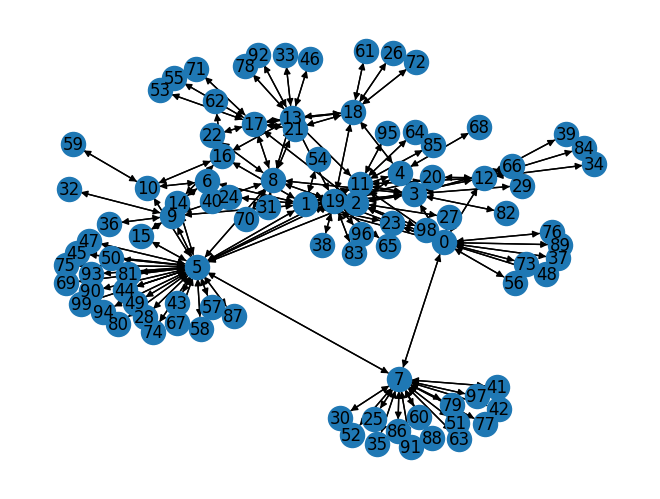

In [3]:
G = nx.DiGraph()
G = nx.random_internet_as_graph(100).to_directed()

nx.draw(G,with_labels=True)
dim = len(G.edges)
degrees = np.array(G.out_degree)
k = degrees[:,1]

In [7]:
# function required to defined unitrary evolution operator-coin, shift and tumbling parameter
def grover(d):

    return 2/d * np.ones((d,d)) - np.identity(d)

def FF(G1):

    #initialize FF operaor
    flipflop = np.zeros((len(G1.edges),len(G1.edges)))

    # find all arcs of the graph
    arcs = np.array(G1.edges)


    for j in np.array(G1.nodes):

        connections = np.where((arcs[:,0] == j)) # which arcs come from j

        for i in arcs[connections[0]][:,1]:
        #loop through arc heads

            # identify basis indices

            id0 = ((arcs == (i,j)).all(axis=1).nonzero())[0][0]

            id1 = ((arcs == (j,i)).all(axis=1).nonzero())[0][0]

            flipflop[id0,id1] = 1

    return flipflop

def grovercoin(G1):

    big_coin = grover(G1.out_degree(0))

    for j in np.array(G1.nodes)[1:]:
        big_coin = block_diag(big_coin,grover(G1.out_degree(j)))

    return big_coin



def tumble(sstate,GG):

    degrees = np.array(GG.out_degree)

    return_state = np.zeros(len(GG.edges),dtype='complex')

    for x in GG.nodes:
            return_state[np.sum(degrees[:x,1]):np.sum(degrees[:x+1,1])] = np.random.permutation(sstate[np.sum(degrees[:x,1]):np.sum(degrees[:x+1,1])])

    return return_state


G = nx.DiGraph()
#G = nx.random_internet_as_graph(6).to_directed()
G=(nx.barabasi_albert_graph(100,2)).to_directed()
#nx.draw(G,with_labels=True)
dim = len(G.edges)
degrees = np.array(G.out_degree)
k = degrees[:,1]




In [8]:
# Paralllise the runs to get the occupation probabilities
# initial statwe  same for every run
init_state = np.zeros(dim, dtype='complex')
init_state[0:G.out_degree(0)] = np.ones(G.out_degree(0)) / np.sqrt(G.out_degree(0))
N_runs = 1000
t = 200
p_tumble = 0.3
dim = len(G.edges)
degrees = np.array(G.out_degree)
S = FF(G)
U = S @ grovercoin(G)
def evolution(init_state):
    global U
    dim = len(G.edges)
    state = init_state.copy()
    occupation = np.zeros((len(G.nodes), t), dtype='complex')


    for j in range(t):
        dec = np.random.rand()
        for x in G.nodes:
            occupation[x,j] = state[np.sum(degrees[:x,1]):np.sum(degrees[:x+1,1])].conjugate() @ state[np.sum(degrees[:x,1]):np.sum(degrees[:x+1,1])].transpose()


        if dec < p_tumble:
            state = tumble(state, G)
        else:
            state = U @ state

    return occupation.real


results_barabasi = np.array(Parallel(n_jobs=-1)(delayed(evolution)(init_state) for i in tqdm(range(N_runs))))




100%|██████████| 1000/1000 [10:15<00:00,  1.62it/s]


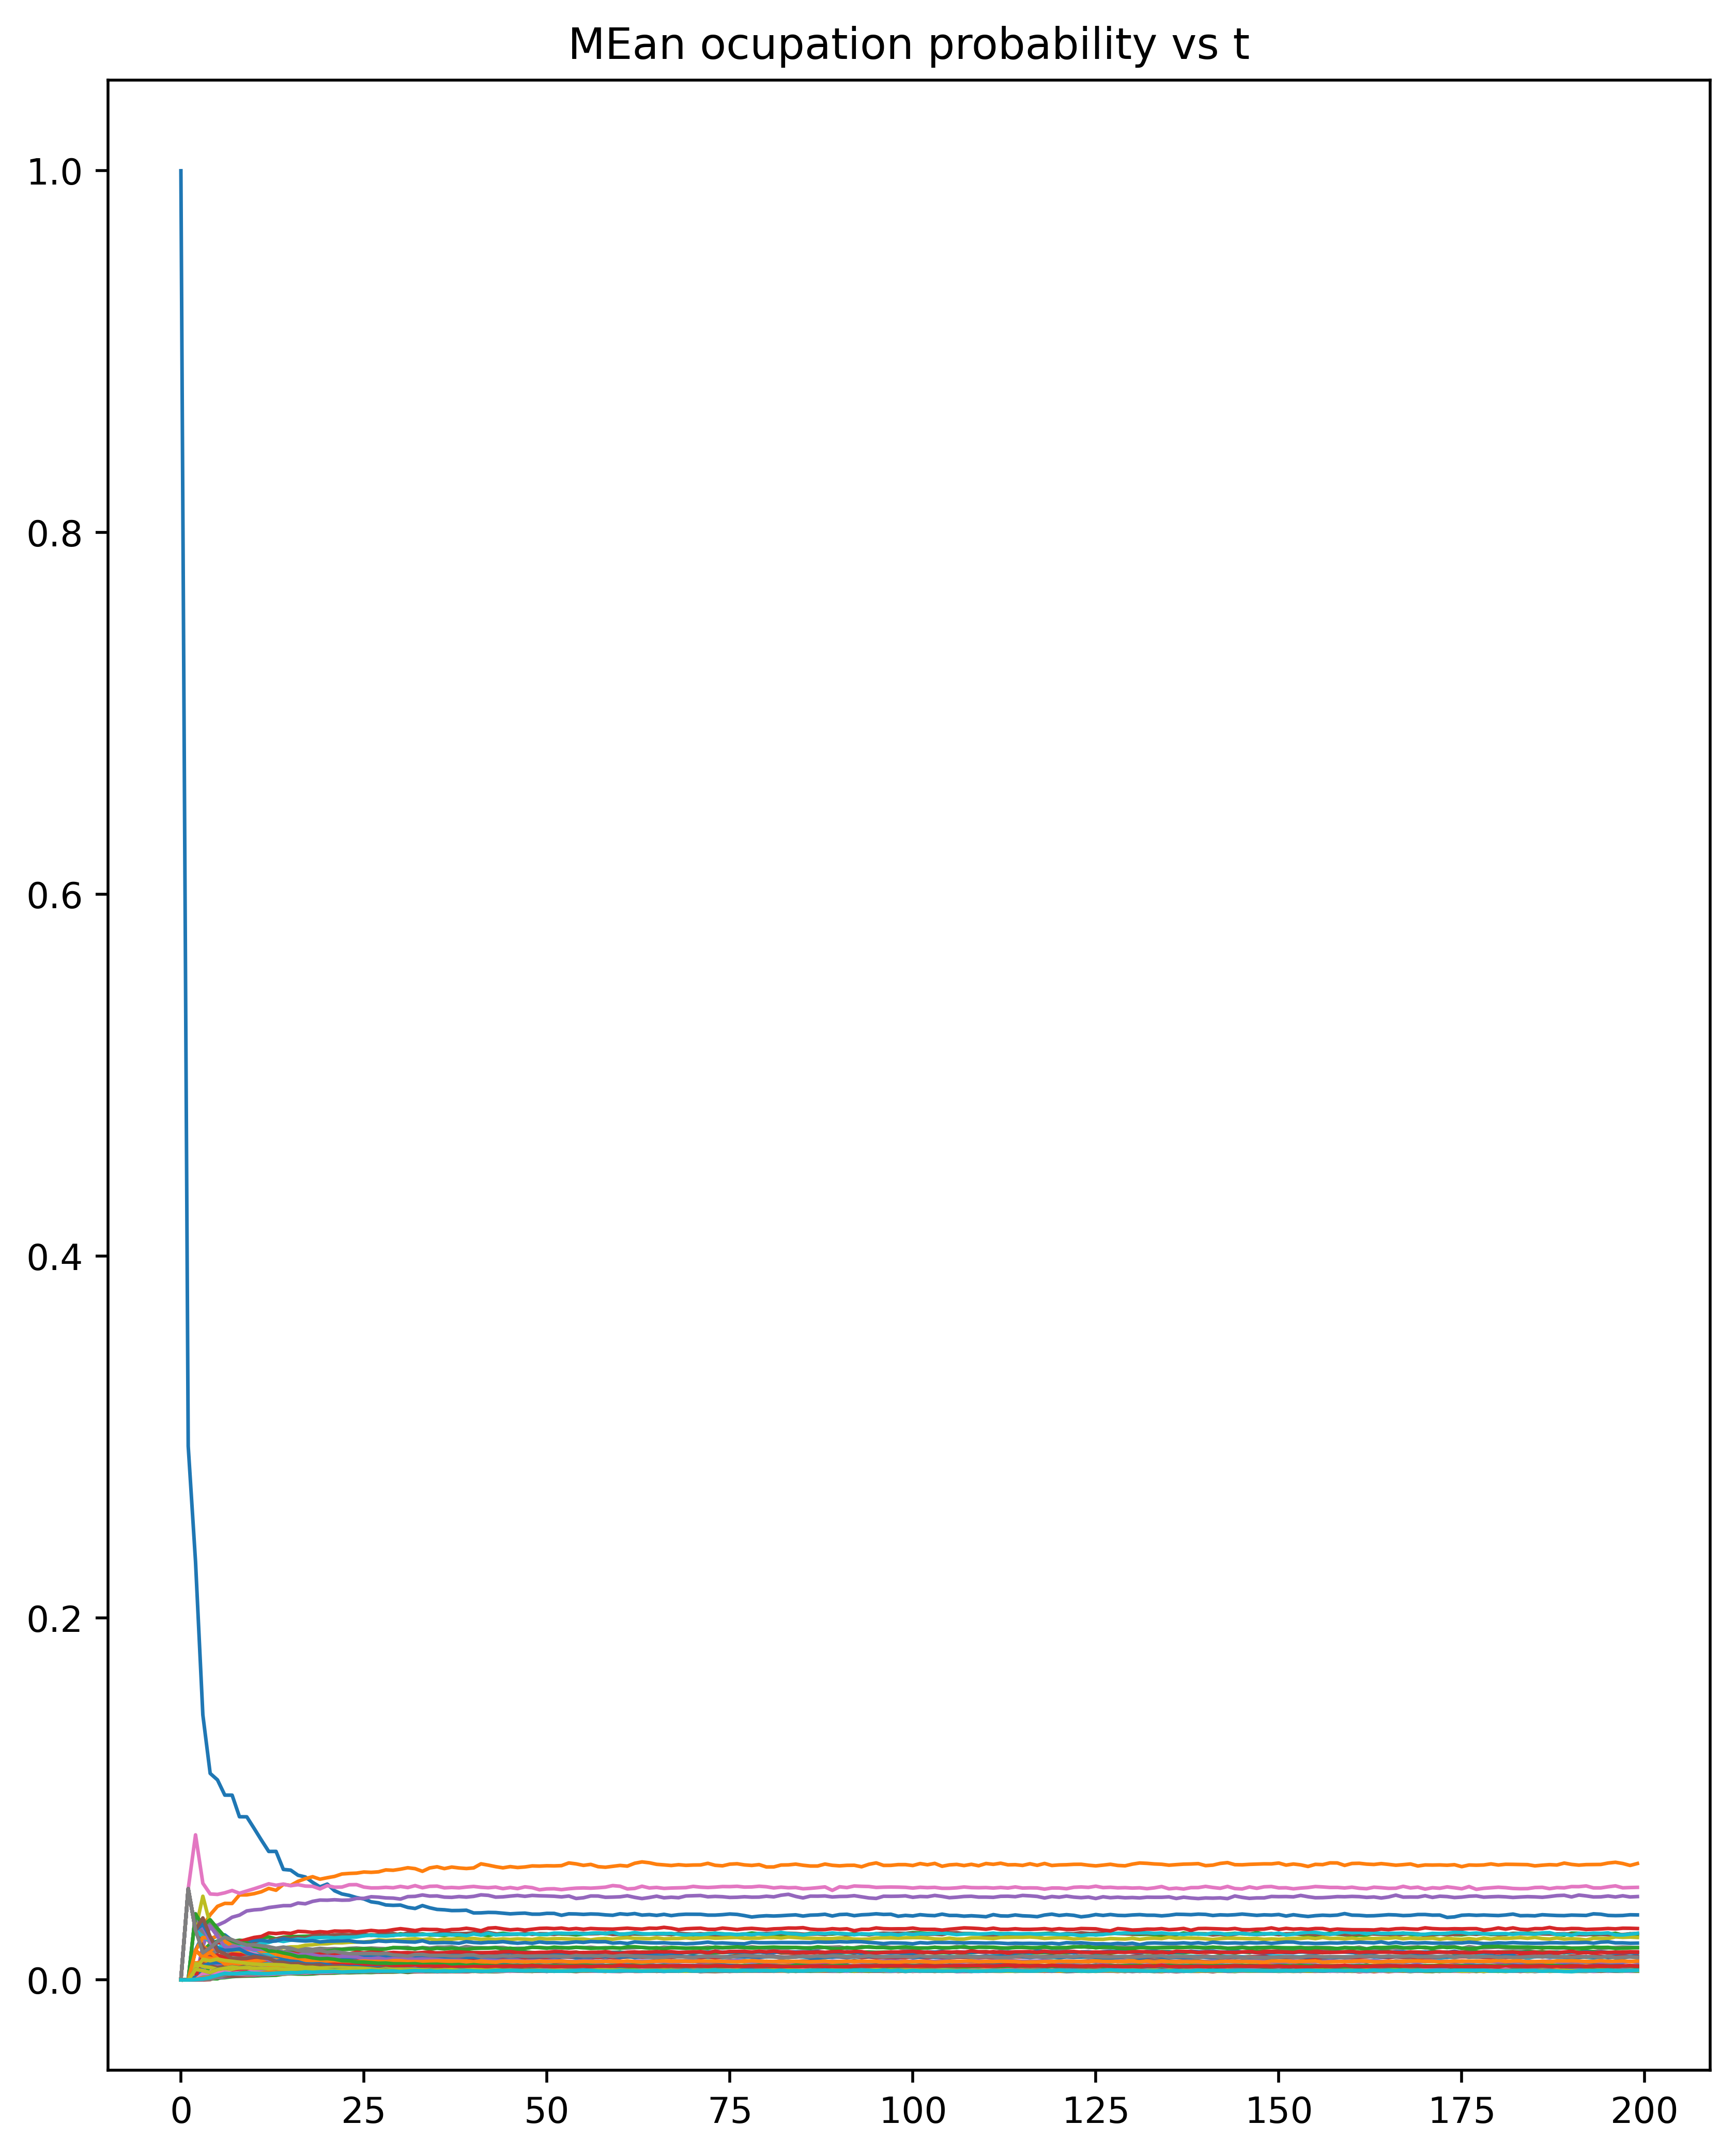

In [9]:
# Plots the mean occupation probabilities of N_runs
avg_over_runs_barabasi= np.sum(results_barabasi, axis=0)
occ_proba_barabasi = avg_over_runs_barabasi / N_runs

plt.figure(figsize=(8,10), dpi=500)
for i in np.array(G.nodes):
    plt.plot(np.arange(t), occ_proba_barabasi[i].real
             , lw=1)
    #plt.xlim(0,20)
    #plt.ylim(0,0.4)
plt.title('MEan ocupation probability vs t')
plt.show()


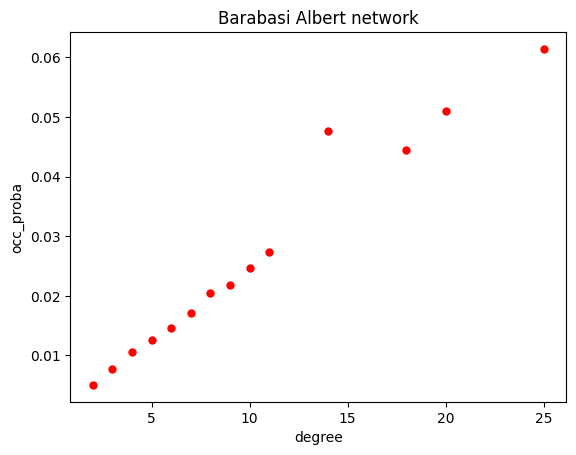

In [11]:
# Plot the occupation probabilities that a node of degree k is occupied by a quantum walker in agraph over runs
mean_occ_nodes_runs_barabasi = results_barabasi.mean(axis=0)
mean_occ_nodes_time_barabasi = mean_occ_nodes_runs_barabasi.mean(axis=1)
degrees_barabasi = np.array([deg for _, deg in G.out_degree()])
# out_degree()
uniq_deg_barabasi = np.unique(degrees_barabasi)

avg_occ_per_degree_barabasi = np.array([ mean_occ_nodes_time_barabasi[degrees_barabasi == k].mean()
    for k in uniq_deg_barabasi
])

plt.plot(figsize=(4, 3.5))


plt.plot(uniq_deg_barabasi,avg_occ_per_degree_barabasi, 'o', color='red', markersize=5)
plt.ylabel("occ_proba")
plt.xlabel("degree")
plt.title("Barabasi Albert network")
plt.show()
